In [1]:
import re
import csv
import random
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# fontpath = os.path.expanduser('~/Downloads/LinLibertine_DRah.ttf')
# prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 12,
#     'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

## Load Annotations

In [3]:
test_df = pd.read_csv('Analysis/test_set_paired.csv')

In [4]:
def load_att_maps(name):
    funny_attentions = []
    funny_attentions_l = np.load(name + '_funny.npz')
    for i in range(len(funny_attentions_l.files)):
        funny_attentions.append(funny_attentions_l['arr_' + str(i)])
    
    serious_attentions = []
    serious_attentions_l = np.load(name + '_serious.npz')
    for i in range(len(serious_attentions_l.files)):
        serious_attentions.append(serious_attentions_l['arr_' + str(i)])
    
    return funny_attentions, serious_attentions

In [5]:
funny_attention_bert_ss, serious_attention_bert_ss = load_att_maps('Analysis/BERT-base-ss-origins-attnmaps/att_map_BERT_ss_full')
# funny_attention_bert_ss, serious_attention_bert_ss = load_att_maps('Analysis/BERT-base-ss-MODTEST-attnmaps/att_map_BERT_ss_full')
# funny_attention_bert_ss, serious_attention_bert_ss = load_att_maps('Analysis/distilBERT-ss-00-attnmaps/att_map_BERT_ss_full')
# funny_attention_robert_ss, serious_attention_robert_ss = load_att_maps('Analysis/RoBERTa-base-ss-00-attnmaps/att_map_BERT_ss_full')

## Head analysis

In [6]:
def attention_mod_head(head, mod_pos):
    seq_len = head.shape[0]
    attention_on_chunk = []
    attention_on_rest = []
    attention_on_sep = []
    attention_on_cls = []
    for s in range(seq_len):
        try:
            att_cls = head[s][0]
            att_sep = head[s][-1]
            att_chunk = np.sum([head[s][p] for p in mod_pos]) / len(mod_pos)
            att_rest = (1 - att_chunk - att_cls - att_sep)/ (seq_len - 2 - len(mod_pos))
#             if math.isnan(att_res) or math.isinf(att_res):
#                 continue
#             print(att_rest)
        except:
            print('here')
            continue
        
        attention_on_chunk.append(att_chunk)
        attention_on_rest.append(att_rest)
        attention_on_sep.append(att_sep)
        attention_on_cls.append(att_cls)
    return np.mean(attention_on_chunk), np.mean(attention_on_rest), np.mean(attention_on_cls), np.mean(attention_on_sep)

def attention_mod(att, mod_pos):
    nb_layers = att.shape[0]
    nb_heads = att.shape[1]
    
    attentions_on_chunk = np.zeros((nb_layers, nb_heads))
    attentions_on_rest = np.zeros((nb_layers, nb_heads))
    attentions_on_sep = np.zeros((nb_layers, nb_heads))
    attentions_on_cls = np.zeros((nb_layers, nb_heads))
    for l in range(nb_layers):
        for h in range(nb_heads):
            c, r, s, cls = attention_mod_head(att[l][h], mod_pos)
            attentions_on_chunk[l][h] = c
            attentions_on_rest[l][h] = r
            attentions_on_sep[l][h] = s
            attentions_on_cls[l][h] = cls
    return attentions_on_chunk, attentions_on_rest, attentions_on_sep, attentions_on_cls

def attention_mod_over_examples(lst_att, lst_mod_pos):
    attentions_on_chunk = []
    attentions_on_rest = []
    attentions_on_sep = []
    attentions_on_cls = []
    for att, mod_pos in zip(lst_att, lst_mod_pos):
        c, r, s, cls = attention_mod(att, mod_pos)
        attentions_on_chunk.append(c)
        attentions_on_rest.append(r)
        attentions_on_sep.append(s)
        attentions_on_cls.append(cls)
    return attentions_on_chunk, attentions_on_rest, attentions_on_sep, attentions_on_cls

In [7]:
def attention_to_list_with_mod_pos(lst_funny_att, lst_serious_att, test_df):
    lst_mod_pos = []
    lst_reduced_funny_att, lst_reduced_serious_att = [], []
    for i in range(test_df.shape[0]):
        row = test_df.iloc[i]
        funny = row['headline_original'].split(' ')
        serious = row['headline_unfunned'].split(' ')
        
        if len(funny) != len(serious):
            continue
        
        if len(funny) < 3:
            continue
        
        if len(set(funny).symmetric_difference(set(serious))) > 2:
            continue
            
        mod_pos = []
        for j in range(len(funny)):
            if funny[j] != serious[j]:
                mod_pos.append(j+1) # Account for the initial token
        
        if len(mod_pos) == 0 or len(mod_pos) > 2:
            continue
            
        
        lst_mod_pos.append(mod_pos)
        lst_reduced_funny_att.append(lst_funny_att[i])
        lst_reduced_serious_att.append(lst_serious_att[i]) 
    
    return attention_mod_over_examples(lst_reduced_funny_att, lst_mod_pos), attention_mod_over_examples(lst_reduced_serious_att, lst_mod_pos)

In [8]:
funny_attention_ss_pos, serious_attention_ss_pos = attention_to_list_with_mod_pos(funny_attention_bert_ss, serious_attention_bert_ss, test_df)
# funny_attention_ss_pos_rob, serious_attention_ss_pos_rob = attention_to_list_with_mod_pos(funny_attention_robert_ss, serious_attention_robert_ss, test_df)

<ipython-input-9-725e93a9889b>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


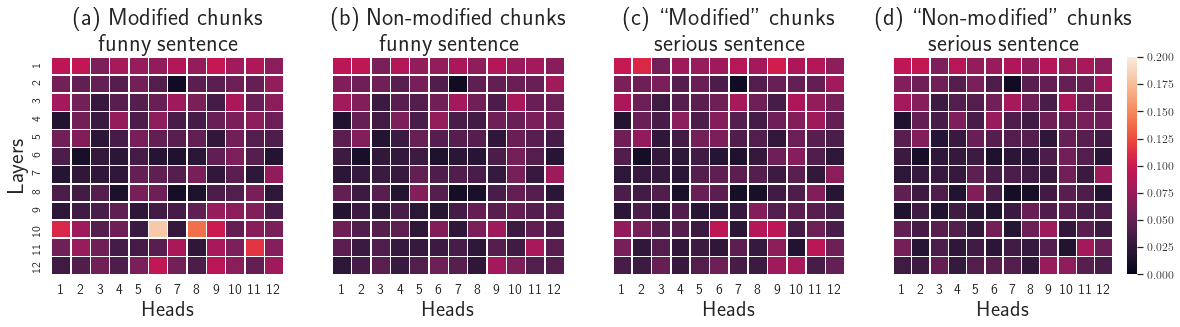

In [9]:
mod_funny, non_mod_funny, _, _ = funny_attention_ss_pos
mod_serious, non_mod_serious, _, _ = serious_attention_ss_pos
# mod_funny, non_mod_funny, _, _ = funny_attention_siamese_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_siamese_pos

# mod_funny, non_mod_funny, _, _ = funny_attention_base_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_base_pos
vmin=0.0
vmax=0.2

grid_kws = {"width_ratios": (.22, .22, .22, .26), "hspace": .2}
fig, axes = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw=grid_kws, sharex=True, sharey=True)
sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title('(a) Modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title('(b) Non-modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[2])
axes[2].set_title('(c) ``Modified" chunks\nserious sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5,vmin=vmin, vmax=vmax,  ax=axes[3])
axes[3].set_title('(d) ``Non-modified" chunks\nserious sentence', fontsize=24)

n_layers = 12
axes[0].set_yticklabels([str(i+1) for i in range(n_layers)])
axes[0].set_ylabel('Layers', fontsize=23)
[axes[i].set_xlabel('Heads', fontsize=22) for i in range(4)]
a = [axes[i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]

fig.tight_layout(pad=1)
# fig.savefig("dbert_ss_mod.pdf", bbox_inches="tight")

<ipython-input-72-f3d4642e921e>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


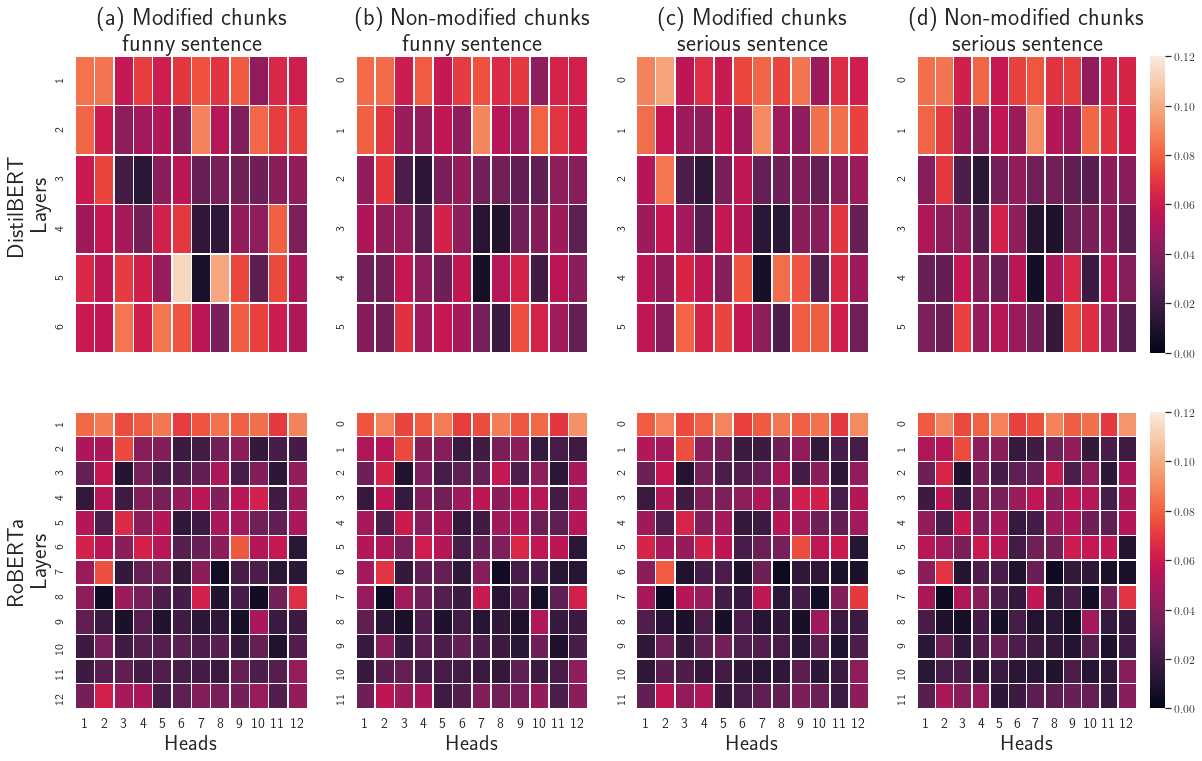

In [72]:
grid_kws = {"width_ratios": (.22, .22, .22, .26), "hspace": .2}
fig, axes_ = plt.subplots(2, 4, figsize=(20, 12), gridspec_kw=grid_kws, sharex=True, sharey=False)

mod_funny, non_mod_funny, _, _ = funny_attention_ss_pos
mod_serious, non_mod_serious, _, _ = serious_attention_ss_pos
# mod_funny, non_mod_funny, _, _ = funny_attention_siamese_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_siamese_pos

# mod_funny, non_mod_funny, _, _ = funny_attention_base_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_base_pos
vmin=0.0
vmax=0.12

axes=axes_[0]

sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title('(a) Modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title('(b) Non-modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[2])
axes[2].set_title('(c) Modified chunks\nserious sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5,vmin=vmin, vmax=vmax,  ax=axes[3])
axes[3].set_title('(d) Non-modified chunks\nserious sentence', fontsize=24)

n_layers = 6
axes[0].set_yticklabels([str(i+1) for i in range(n_layers)])
axes[0].set_ylabel('DistilBERT \n Layers', fontsize=23)
# [axes[i].set_xlabel('Heads', fontsize=22) for i in range(4)]
a = [axes[i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]

mod_funny, non_mod_funny, _, _ = funny_attention_ss_pos_rob
mod_serious, non_mod_serious, _, _ = serious_attention_ss_pos_rob
# mod_funny, non_mod_funny, _, _ = funny_attention_siamese_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_siamese_pos

# mod_funny, non_mod_funny, _, _ = funny_attention_base_pos
# mod_serious, non_mod_serious, _, _ = serious_attention_base_pos
vmin=0.0
vmax=0.12

axes=axes_[1]

sns.heatmap(np.mean(np.array(mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[0])
# axes[0].set_title('(a) Modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_funny), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[1])
# axes[1].set_title('(b) Non-modified chunks\nfunny sentence', fontsize=24)
sns.heatmap(np.mean(np.array(mod_serious), axis=0), cbar=False, linewidth=0.5, vmin=vmin, vmax=vmax, ax=axes[2])
# axes[2].set_title('(c) ``Modified" chunks\nserious sentence', fontsize=24)
sns.heatmap(np.mean(np.array(non_mod_serious), axis=0), linewidth=0.5,vmin=vmin, vmax=vmax,  ax=axes[3])
# axes[3].set_title('(d) ``Non-modified" chunks\nserious sentence', fontsize=24)

n_layers = 12
axes[0].set_yticklabels([str(i+1) for i in range(n_layers)])
axes[0].set_ylabel('RoBERTa \n Layers', fontsize=23)
[axes[i].set_xlabel('Heads', fontsize=22) for i in range(4)]
a = [axes[i].set_xticklabels([str(i+1) for i in range(12)]) for i in range(4)]

fig.tight_layout(pad=1)
# fig.savefig("dbert_roberta_ss_mod.pdf", bbox_inches="tight")

## Examples

In [29]:
ss_setup_error_analysis_df = pd.read_csv('../LaughingHeads/Analysis/SS_error_analysis.csv')

In [90]:
def predict_with_head_chunk(att):
    return np.argmax(np.sum(att[9][5], axis=0))

def evaluate_head_chunk(df, lst_att):
    answer = []
    rand = []
    res = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        funny = row['headline_original'].split(' ')
        serious = row['headline_unfunned'].split(' ')
        
        if len(funny) != len(serious):
            continue
        
        if len(funny) < 3:
            continue
        
        if len(set(funny).symmetric_difference(set(serious))) > 2:
            continue
        
        if row['predicted_headline_original'] != 'funny':
            continue
        
        mod_pos = []
        for j in range(len(funny)):
            if funny[j] != serious[j]:
                mod_pos.append(j+1)

        if predict_with_head_chunk(lst_att[i]) in mod_pos:
            answer.append(1.)
            
#             print(funny)
#             print(np.sum(lst_att[i][9][5], axis=0))
#             tt+=1
#             print(tt)
            res.append([funny, np.sum(lst_att[i][9][5], axis=0)])
    return res

In [91]:
res = evaluate_head_chunk(ss_setup_error_analysis_df, funny_attention_bert_ss)

In [144]:
def plot_bar(data, i):
    res = data[i]
    fig, ax = plt.subplots(1,1, figsize=(15,2))
    
    sentence, attention = res
    value = attention[1:-1]
    x = range(len(sentence))
    
    ax.bar(x, value)
    ax.set_xticks(x)
    ax.set_xticklabels(sentence, fontsize=22, rotation=30)
    ax.grid(False)
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fig.show()
    fig.savefig("example_{}.pdf".format(i), bbox_inches="tight")

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


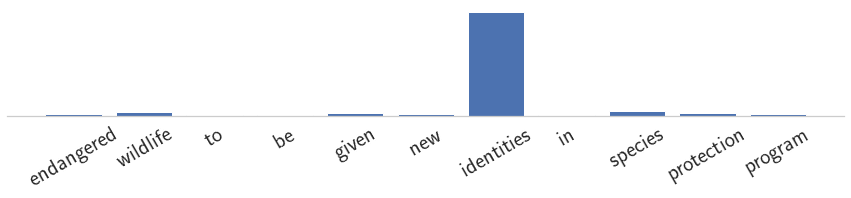

In [145]:
plot_bar(res, 0)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


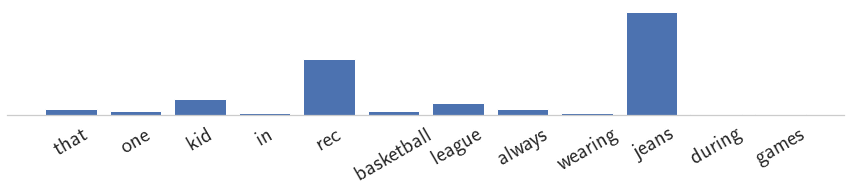

In [146]:
plot_bar(res, 1)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


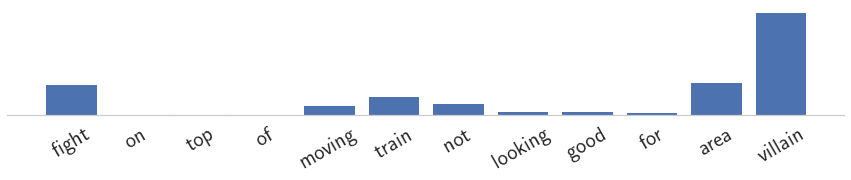

In [147]:
plot_bar(res, 2)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


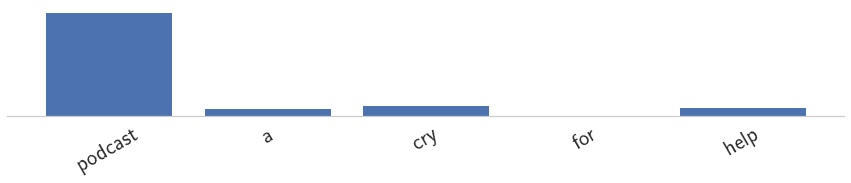

In [148]:
plot_bar(res, 4)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


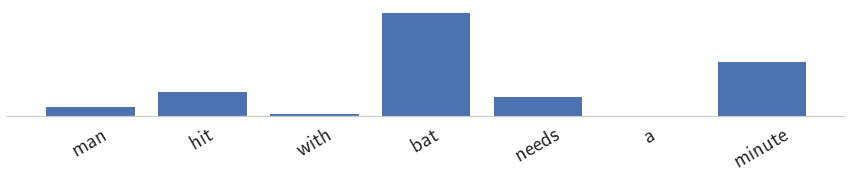

In [149]:
plot_bar(res, 5)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


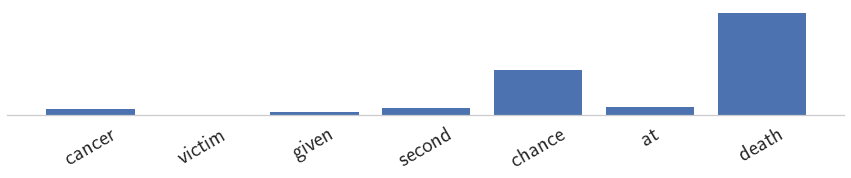

In [150]:
plot_bar(res, 11)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


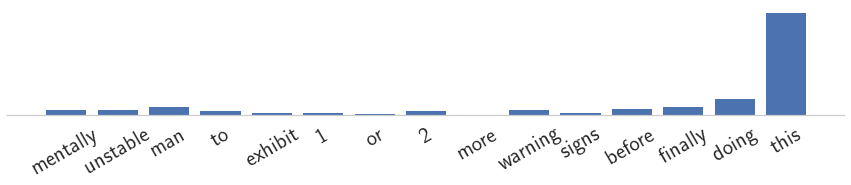

In [151]:
plot_bar(res, 12)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


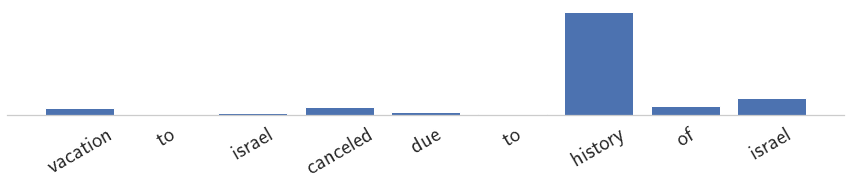

In [154]:
plot_bar(res, 13)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


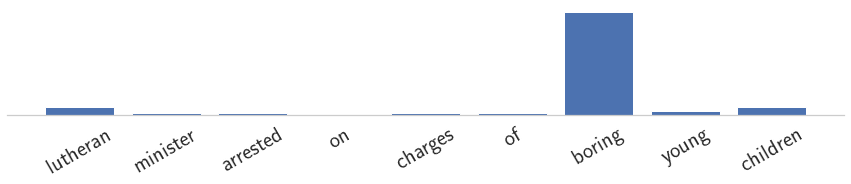

In [153]:
plot_bar(res, 15)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


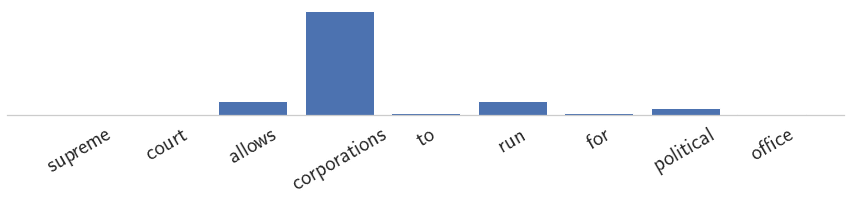

In [152]:
plot_bar(res, 18)

<ipython-input-144-5429ab114101>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


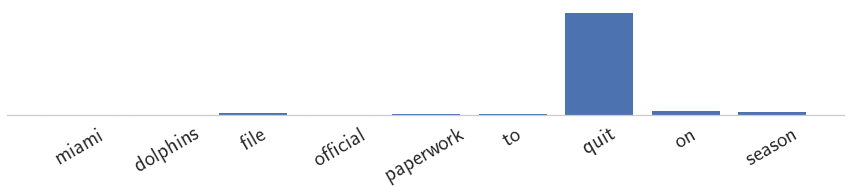

In [155]:
plot_bar(res, 19)